In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

import keras
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

warnings.filterwarnings(action="ignore")
%matplotlib inline

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [2]:
# Define file paths
healthy_dirs = [
    'test/NORMAL',
    'train/NORMAL',
    'val/NORMAL',
]

pneumonia_dir = [ 
    'test/PNEUMONIA',
    'train/PNEUMONIA',
    'val/PNEUMONIA',
]

In [3]:
filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

                       filepaths  labels
0  test/NORMAL\IM-0001-0001.jpeg  Normal
1  test/NORMAL\IM-0003-0001.jpeg  Normal
2  test/NORMAL\IM-0005-0001.jpeg  Normal
3  test/NORMAL\IM-0006-0001.jpeg  Normal
4  test/NORMAL\IM-0007-0001.jpeg  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


In [4]:
pneumonia_df.shape

(5856, 2)

In [5]:
train_images, test_images = train_test_split(pneumonia_df, test_size=0.15, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.17, random_state=42)
print(train_images.shape)
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)

(4977, 2)
(4130, 2)
(879, 2)
(847, 2)


In [6]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 4130 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.
Found 847 validated image filenames belonging to 2 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)


def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
    show_knee_images(train)

['Normal', 'Pneumonia']


In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 73, 73, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                        

In [9]:
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', # You can also use 'val_accuracy' depending on your goal
                               patience=3,        # Number of epochs to wait after no improvement
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
                               verbose=1)

In [10]:
# Fit the model with early stopping
history = model.fit(train,
                    validation_data=val,
                    epochs=6,   # You can set a high number, early stopping will stop earlier if there's no improvement
                    callbacks=[early_stopping],  # Pass early stopping in the callbacks list
                    verbose=1)

Epoch 1/6
1033/1033 [==============================] - 729s 704ms/step - loss: 0.4867 - accuracy: 0.8496 - val_loss: 0.1795 - val_accuracy: 0.9327
Epoch 2/6
1033/1033 [==============================] - 719s 696ms/step - loss: 0.2444 - accuracy: 0.9126 - val_loss: 0.1849 - val_accuracy: 0.9339
Epoch 3/6
1033/1033 [==============================] - 716s 693ms/step - loss: 0.1812 - accuracy: 0.9320 - val_loss: 0.1539 - val_accuracy: 0.9362
Epoch 4/6
1033/1033 [==============================] - 718s 695ms/step - loss: 0.1384 - accuracy: 0.9501 - val_loss: 0.1420 - val_accuracy: 0.9433
Epoch 5/6
1033/1033 [==============================] - 718s 695ms/step - loss: 0.1072 - accuracy: 0.9579 - val_loss: 0.1410 - val_accuracy: 0.9504
Epoch 6/6
1033/1033 [==============================] - 721s 698ms/step - loss: 0.1006 - accuracy: 0.9625 - val_loss: 0.1267 - val_accuracy: 0.9540


In [11]:
model.evaluate(test, verbose=1)

220/220 [==============================] - 33s 150ms/step - loss: 0.1399 - accuracy: 0.9613


[0.13993628323078156, 0.9613196849822998]

In [12]:
model.save("pneumonia_Model.h5")
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

220/220 [==============================] - 33s 148ms/step


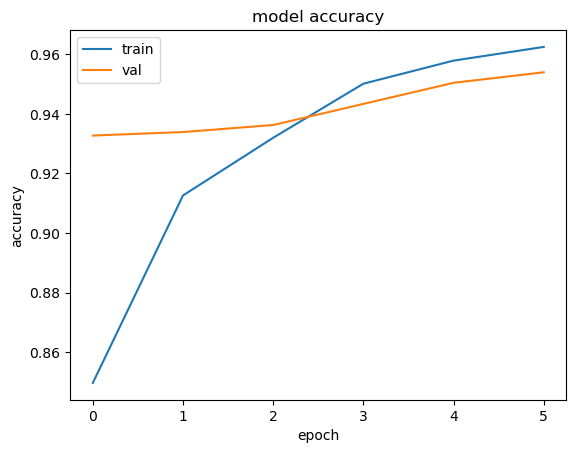

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

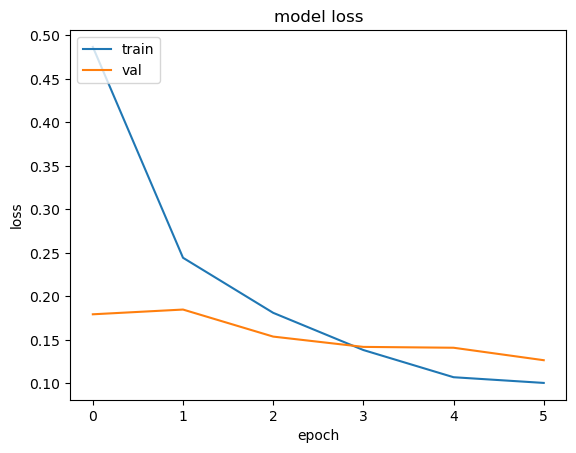

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       269
   Pneumonia       0.97      0.98      0.97       610

    accuracy                           0.96       879
   macro avg       0.96      0.95      0.95       879
weighted avg       0.96      0.96      0.96       879

Accuracy of the Model: 96.1%


In [16]:
cm = confusion_matrix(y_test, pred2)
print(cm)

[[249  20]
 [ 14 596]]
